# Technical  skill test  - Data Science Internship

Machine Learning   

**Instructors**  
Vanessa Trinh - Data Science - Henkel Global Supply Chain B.V
<span style='color:crimson; font-weight: bold'>Submission deadline: 22 October 2021, 2pm CET</span>

## Instructions

* We strongly encourage you to experiment, try different approaches and combinations and get to know the problem from alternative angles.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score,classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import RepeatedKFold
from sklearn import linear_model
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
import os

## Introduction

"*Insurance fraud is any act committed to defraud an insurance process. This occurs when a claimant attempts to obtain some benefit or advantage they are not entitled to, or when an insurer knowingly denies some benefit that is due.*" -- [Wikipedia](https://en.wikipedia.org/wiki/Insurance_fraud)

How can we predict, if an insurance claim was fraudulent or not? This dataset contains the information of insurance contracts where some are identified to be a fraud (`fraud=Y`). From the 38 features, we want to find an optimal way to classify the claims. 

* We also want to point out, that the data below only represents a starting point. We encourage you to come up with new features based on them, i.e. feature engineering.


In [2]:
path = os.path.join('insurance_claims.csv')

df_data = pd.read_csv(path)
df_data.head(2)

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,17-10-14,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,25-01-15,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,27-06-06,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,21-01-15,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y


## Preparation

Before we start the analysis, we prepare the data by labelling them correctly and splitting into targets and features. We will start with a binary classification (`fraud_reported`).

In [3]:
target_name = 'fraud_reported'

# `sr_` prefix stands for a pandas Series
sr_targets = df_data.loc[:,target_name]
sr_targets = (sr_targets == 'Y').astype(int)

These targets can take on two values.

In [4]:
label_values = [1,0]
label_names = ['fraudulent', 'valid']

The features are as described above. Let us use the short names from now on and extract those from the dataset.

In [5]:
# `df_` prefix stands for a pandas DataFrame
df_features_raw = df_data.drop(target_name, axis=1)

# Question 1

Get familiar with the data. Use visual aids to get an overview of the data. Find descriptives about the data, in particular, how do you treat missing values and outliers? 

You see below that the dataframe contains different data types. Pre-process the data as you see necessary. How do you treat the different data types? Create, remove, modify, transform or combine features as you see fit.

**Hint:** Don't aim at finishing this question right at the beginning. It's likely that you will come back to this step when solving the subsequent questions.

In [6]:
df_features_raw.dtypes

months_as_customer               int64
age                              int64
policy_number                    int64
policy_bind_date                object
policy_state                    object
policy_csl                      object
policy_deductable                int64
policy_annual_premium          float64
umbrella_limit                   int64
insured_zip                      int64
insured_sex                     object
insured_education_level         object
insured_occupation              object
insured_hobbies                 object
insured_relationship            object
capital-gains                    int64
capital-loss                     int64
incident_date                   object
incident_type                   object
collision_type                  object
incident_severity               object
authorities_contacted           object
incident_state                  object
incident_city                   object
incident_location               object
incident_hour_of_the_day 

In [7]:
# Your answer
df_data.describe()

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,203.954000,38.948000,546238.648000,1136.000000,1256.406150,1.101000e+06,501214.488000,25126.100000,-26793.700000,11.644000,1.83900,0.992000,1.487000,52761.94000,7433.420000,7399.570000,37928.950000,2005.103000
std,115.113174,9.140287,257063.005276,611.864673,244.167395,2.297407e+06,71701.610941,27872.187708,28104.096686,6.951373,1.01888,0.820127,1.111335,26401.53319,4880.951853,4824.726179,18886.252893,6.015861
min,0.000000,19.000000,100804.000000,500.000000,433.330000,-1.000000e+06,430104.000000,0.000000,-111100.000000,0.000000,1.00000,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000,1995.000000
25%,115.750000,32.000000,335980.250000,500.000000,1089.607500,0.000000e+00,448404.500000,0.000000,-51500.000000,6.000000,1.00000,0.000000,1.000000,41812.50000,4295.000000,4445.000000,30292.500000,2000.000000
50%,199.500000,38.000000,533135.000000,1000.000000,1257.200000,0.000000e+00,466445.500000,0.000000,-23250.000000,12.000000,1.00000,1.000000,1.000000,58055.00000,6775.000000,6750.000000,42100.000000,2005.000000
75%,276.250000,44.000000,759099.750000,2000.000000,1415.695000,0.000000e+00,603251.000000,51025.000000,0.000000,17.000000,3.00000,2.000000,2.000000,70592.50000,11305.000000,10885.000000,50822.500000,2010.000000
max,479.000000,64.000000,999435.000000,2000.000000,2047.590000,1.000000e+07,620962.000000,100500.000000,0.000000,23.000000,4.00000,2.000000,3.000000,114920.00000,21450.000000,23670.000000,79560.000000,2015.000000


'?' in the datsetis replaced by NaN Values->checking for null values in the dataset.

In [8]:
df_data = df_data.replace('?',np.NaN)
df_data.isnull().any()

months_as_customer             False
age                            False
policy_number                  False
policy_bind_date               False
policy_state                   False
policy_csl                     False
policy_deductable              False
policy_annual_premium          False
umbrella_limit                 False
insured_zip                    False
insured_sex                    False
insured_education_level        False
insured_occupation             False
insured_hobbies                False
insured_relationship           False
capital-gains                  False
capital-loss                   False
incident_date                  False
incident_type                  False
collision_type                  True
incident_severity              False
authorities_contacted          False
incident_state                 False
incident_city                  False
incident_location              False
incident_hour_of_the_day       False
number_of_vehicles_involved    False
p


Replace the NaN by the most common collision type as we are unaware of the type -> replace no responses for property damage with No property damage -> replace no responses for police report available with No report available -> check for any remaining null values.

In [9]:
df_data['collision_type'].fillna(df_data['collision_type'].mode()[0], inplace = True)
df_data['property_damage'].fillna('NO', inplace = True)
df_data['police_report_available'].fillna('NO', inplace = True)
df_data.isnull().any().any()

False

Check number of unique values in each cell.

In [10]:
df_data.nunique()

months_as_customer              391
age                              46
policy_number                  1000
policy_bind_date                951
policy_state                      3
policy_csl                        3
policy_deductable                 3
policy_annual_premium           991
umbrella_limit                   11
insured_zip                     995
insured_sex                       2
insured_education_level           7
insured_occupation               14
insured_hobbies                  20
insured_relationship              6
capital-gains                   338
capital-loss                    354
incident_date                    60
incident_type                     4
collision_type                    3
incident_severity                 4
authorities_contacted             5
incident_state                    7
incident_city                     7
incident_location              1000
incident_hour_of_the_day         24
number_of_vehicles_involved       4
property_damage             

Check for multicollinearity.

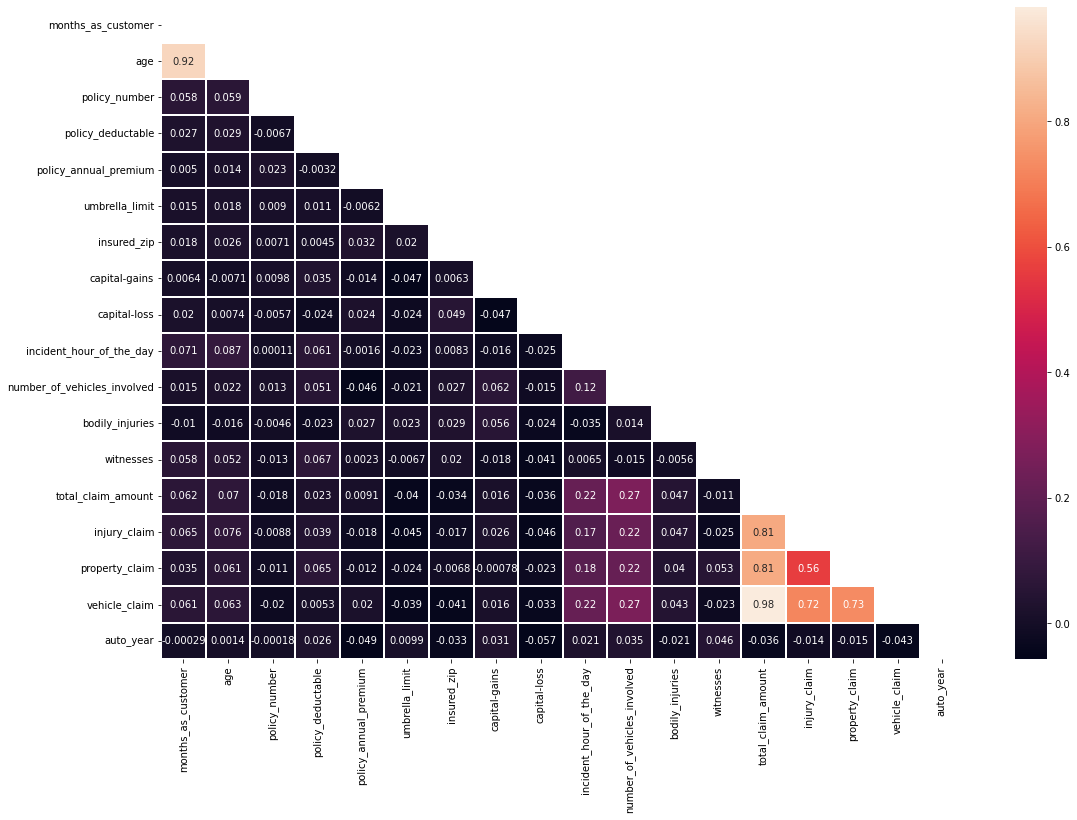

In [11]:
plt.figure(figsize = (18, 12))
corr = df_data.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(data = corr, mask = mask, annot = True, fmt = '.2g', linewidth = 1)
plt.show()

From the above plot, we can see that there is high correlation between age and months_as_customer.We will drop the "Age" column.Also there is high correlation between total_clam_amount, injury_claim,property_claim, vehicle_claim as total claim is the sum of all others. 
So we will drop the "total_claim" column.

In [12]:
df_data.drop(columns = ['age', 'total_claim_amount'], inplace = True, axis = 1)

Check data types of each cells.

In [13]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   policy_number                1000 non-null   int64  
 2   policy_bind_date             1000 non-null   object 
 3   policy_state                 1000 non-null   object 
 4   policy_csl                   1000 non-null   object 
 5   policy_deductable            1000 non-null   int64  
 6   policy_annual_premium        1000 non-null   float64
 7   umbrella_limit               1000 non-null   int64  
 8   insured_zip                  1000 non-null   int64  
 9   insured_sex                  1000 non-null   object 
 10  insured_education_level      1000 non-null   object 
 11  insured_occupation           1000 non-null   object 
 12  insured_hobbies              1000 non-null   object 
 13  insured_relationshi

Check correlation of various columns with target -> encode them into numerical values.

In [14]:
df_data['policy_bind_date'] = pd.to_datetime(df_data['policy_bind_date'], errors = 'coerce')
df_data['fraud_reported'] = df_data['fraud_reported'].replace(('Y','N'),(0,1))
#df_data['fraud_reported'].value_counts()

In [15]:
df_data[['auto_make','fraud_reported']].groupby(['auto_make'], 
                as_index = False).mean().sort_values(by = 'fraud_reported', ascending = False)

,auto_make,fraud_reported
7,Jeep,0.835821
9,Nissan,0.820513
12,Toyota,0.814286
0,Accura,0.808824
10,Saab,0.775000
11,Suburu,0.762500
4,Dodge,0.750000
6,Honda,0.745455
3,Chevrolet,0.723684
2,BMW,0.722222


In [16]:
df_data['auto_make'] = df_data['auto_make'].replace(('Jeep','Nissan','Toyota','Accura','Saab','Suburu',
                                'Dodge','Honda','Chevrolet','BMW','Volkswagen','Audi','Ford','Mercedes'),
                                              (0.84,0.82,0.81,0.80,0.77,0.76,0.75,0.74,0.73,0.72,0.71,0.69,0.69,0.66))

#df_data['auto_make'].value_counts()

In [17]:
df_data[['police_report_available','fraud_reported']].groupby(['police_report_available'], 
                as_index = False).mean().sort_values(by = 'fraud_reported', ascending = False)

,police_report_available,fraud_reported
1,YES,0.770701
0,NO,0.744898


In [18]:
df_data['police_report_available'] = df_data['police_report_available'].replace(('NO','YES'),(0.77,0.74))
#df_data['police_report_available'].value_counts()

In [19]:
df_data[['property_damage','fraud_reported']].groupby(['property_damage'], 
                as_index = False).mean().sort_values(by = 'fraud_reported', ascending = False)

,property_damage,fraud_reported
0,NO,0.757880
1,YES,0.741722


In [20]:
df_data['property_damage'] = df_data['property_damage'].replace(('NO','YES'),(0.76,0.74))
#df_data['property_damage'].value_counts()

In [21]:
df_data[['authorities_contacted','fraud_reported']].groupby(['authorities_contacted'], 
                as_index = False).mean().sort_values(by = 'fraud_reported', ascending = False)

,authorities_contacted,fraud_reported
2,None,0.934066
4,Police,0.791096
1,Fire,0.730942
0,Ambulance,0.709184
3,Other,0.681818


In [22]:
df_data['authorities_contacted'] = df_data['authorities_contacted'].replace(('None','Police','Fire','Ambulance','Other'),
                                                                      (0.94,0.79,0.73,0.70,0.68))
#df_data['authorities_contacted'].value_counts()

In [23]:
df_data[['incident_city','fraud_reported']].groupby(['incident_city'], 
                as_index = False).mean().sort_values(by = 'fraud_reported', ascending = False)

,incident_city,fraud_reported
4,Northbrook,0.778689
5,Riverwood,0.776119
3,Northbend,0.765517
6,Springfield,0.757962
2,Hillsdale,0.751773
1,Columbus,0.738255
0,Arlington,0.710526


In [24]:
df_data['incident_city'] = df_data['incident_city'].replace(('Northbrook','Riverwood','Northbend','Springfield',
                                    'Hillsdale','Columbus','Arlington'),(0.78,0.77,0.76,0.75,0.74,0.73,0.71))
#df_data['incident_city'].value_counts()

In [25]:
df_data[['incident_state','fraud_reported']].groupby(['incident_state'], 
                as_index = False).mean().sort_values(by = 'fraud_reported', ascending = False)

,incident_state,fraud_reported
6,WV,0.820276
1,NY,0.778626
5,VA,0.772727
3,PA,0.733333
4,SC,0.705645
0,NC,0.690909
2,OH,0.565217


In [26]:
df_data['incident_state'] = df_data['incident_state'].replace(('WV','NY','VA','PA','SC','NC','OH'),
                                                        (0.82,0.77,0.76,0.73,0.70,0.69,0.56))
#df_data['incident_state'].value_counts()

In [27]:
df_data[['incident_severity','fraud_reported']].groupby(['incident_severity'], 
                as_index = False).mean().sort_values(by = 'fraud_reported', ascending = False)

,incident_severity,fraud_reported
3,Trivial Damage,0.933333
1,Minor Damage,0.892655
2,Total Loss,0.871429
0,Major Damage,0.394928


In [28]:
df_data['incident_severity'] = df_data['incident_severity'].replace(('Trivial Damage','Minor Damage','Total Loss',
                                                              'Major Damage'),(0.94,0.89,0.87,0.39))
#df_data['incident_severity'].value_counts()

In [29]:
df_data[['collision_type','fraud_reported']].groupby(['collision_type'], 
                as_index = False).mean().sort_values(by = 'fraud_reported', ascending = False)

,collision_type,fraud_reported
1,Rear Collision,0.772340
2,Side Collision,0.746377
0,Front Collision,0.724409


In [30]:
df_data['collision_type'] = df_data['collision_type'].replace(('Rear Collision', 'Side Collision', 'Front Collision'),
                                                        (0.78,0.74,0.72))
#df_data['collision_type'].value_counts()

In [31]:
df_data[['incident_type','fraud_reported']].groupby(['incident_type'], 
                as_index = False).mean().sort_values(by = 'fraud_reported', ascending = False)

,incident_type,fraud_reported
3,Vehicle Theft,0.914894
1,Parked Car,0.904762
0,Multi-vehicle Collision,0.727924
2,Single Vehicle Collision,0.709677


In [32]:
df_data['incident_type'] = df_data['incident_type'].replace(('Vehicle Theft','Parked Car','Multi-vehicle Collision',
                                'Single Vehicle Collision'),(0.91, 0.90, 0.72,0.70))
#df_data['incident_type'].value_counts()

In [33]:
df_data[['insured_relationship','fraud_reported']].groupby(['insured_relationship'], 
                as_index = False).mean().sort_values(by = 'fraud_reported', ascending = False)

,insured_relationship,fraud_reported
0,husband,0.794118
3,own-child,0.786885
4,unmarried,0.758865
1,not-in-family,0.741379
5,wife,0.729032
2,other-relative,0.706215


In [34]:
df_data['insured_relationship'] = df_data['insured_relationship'].replace(('husband','own-child','unmarried',
                                        'not-in-family','wife','other-relative'),(0.79,0.78,0.75,0.74,0.72,0.70))
#df_data['insured-relationship'].value_counts()

In [35]:
df_data[['insured_hobbies','fraud_reported']].groupby(['insured_hobbies'], 
                as_index = False).mean().sort_values(by = 'fraud_reported', ascending = False)

,insured_hobbies,fraud_reported
4,camping,0.909091
11,kayaking,0.907407
9,golf,0.890909
7,dancing,0.883721
3,bungie-jumping,0.839286
12,movies,0.836364
1,basketball,0.823529
8,exercise,0.807018
17,sleeping,0.804878
18,video-games,0.800000


In [36]:
df_data['insured_hobbies'] = df_data['insured_hobbies'].replace(('camping', 'kayaking', 'golf','dancing',
        'bungie-jumping','movies', 'basketball','exercise','sleeping','video-games','skydiving','paintball',
            'hiking','base-jumping','reading','polo','board-games','yachting', 'cross-fit','chess'),(0.91, 0.90,
                0.89, 0.88,0.84,0.83,0.82,0.81,0.805,0.80,0.78,0.77,0.76,0.73,0.73,0.72,0.70,0.69,0.25,0.17))
#df_data['insured_hobbies'].value_counts()

In [37]:
df_data[['insured_occupation','fraud_reported']].groupby(['insured_occupation'], 
                as_index = False).mean().sort_values(by = 'fraud_reported', ascending = False)

,insured_occupation,fraud_reported
7,other-service,0.830986
8,priv-house-serv,0.830986
0,adm-clerical,0.830769
5,handlers-cleaners,0.796296
9,prof-specialty,0.788235
10,protective-serv,0.777778
6,machine-op-inspct,0.763441
1,armed-forces,0.753623
11,sales,0.723684
12,tech-support,0.717949


In [38]:
df_data['insured_occupation'] = df_data['insured_occupation'].replace(('other-service','priv-house-serv',
                        'adm-clerical','handlers-cleaners','prof-specialty','protective-serv',
                'machine-op-inspct','armed-forces','sales','tech-support','transport-moving','craft-repair',
                    'farming-fishing','exec-managerial'),(0.84, 0.84,0.83, 0.79,0.78,0.77,0.76,0.75,0.72,0.71,
                                                          0.705,0.70,0.69,0.63))
#df_data['insured_occupation'].value_counts()

In [39]:
df_data[['insured_education_level','fraud_reported']].groupby(['insured_education_level'], 
                as_index = False).mean().sort_values(by = 'fraud_reported', ascending = False)

,insured_education_level,fraud_reported
5,Masters,0.776224
2,High School,0.775000
0,Associate,0.765517
3,JD,0.739130
1,College,0.737705
4,MD,0.736111
6,PhD,0.736000


In [40]:
df_data['insured_education_level'] = df_data['insured_education_level'].replace(('Masters', 'High School','Associate',
                                        'JD','College', 'MD','PhD'),(0.78,0.77,0.76,0.74,0.73,0.72,0.71))
#df_data['insured_education_level'].value_counts()

In [41]:
df_data[['insured_sex','fraud_reported']].groupby(['insured_sex'], as_index = False).mean().sort_values(
    by = 'fraud_reported', ascending = False)

,insured_sex,fraud_reported
0,FEMALE,0.765363
1,MALE,0.738661


In [42]:
df_data['insured_sex'] = df_data['insured_sex'].replace(('FEMALE','MALE'),(0.76,0.73))
#df_data['insured_sex'].value_counts()

In [43]:
df_data[['policy_csl','fraud_reported']].groupby(['policy_csl'], as_index = False).mean().sort_values(
    by = 'fraud_reported', ascending = False)

,policy_csl,fraud_reported
2,500/1000,0.783333
0,100/300,0.742120
1,250/500,0.737892


In [44]:
df_data['policy_csl'] = df_data['policy_csl'].replace(('500/1000','100/300','250/500'),(0.78,0.74,0.73))

#df_data['policy_csl'].value_counts()

In [45]:
df_data[['policy_state','fraud_reported']].groupby(['policy_state'], as_index = False).mean().sort_values(
    by = 'fraud_reported', ascending = False)

,policy_state,fraud_reported
0,IL,0.772189
1,IN,0.745161
2,OH,0.741477


In [46]:
df_data['policy_state'] = df_data['policy_state'].replace(('IL','IN','OH'),(0.77,0.745,0.74))

#df_data['policy_state'].value_counts()

We delete unnecassary columns which i think is not really a part of deciding factor of whether it is a fraud or not and check remaining columns.

In [47]:
df_data = df_data.drop(['policy_number','policy_bind_date', 'incident_date','incident_location','auto_model'], axis = 1)
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   policy_state                 1000 non-null   float64
 2   policy_csl                   1000 non-null   float64
 3   policy_deductable            1000 non-null   int64  
 4   policy_annual_premium        1000 non-null   float64
 5   umbrella_limit               1000 non-null   int64  
 6   insured_zip                  1000 non-null   int64  
 7   insured_sex                  1000 non-null   float64
 8   insured_education_level      1000 non-null   float64
 9   insured_occupation           1000 non-null   float64
 10  insured_hobbies              1000 non-null   float64
 11  insured_relationship         1000 non-null   float64
 12  capital-gains                1000 non-null   int64  
 13  capital-loss       

# Question 2 

Inspect the data and set up a suitable cross validator object from `sklearn.model_selection` to use for this test. Discuss the reasoning behind the cross validator of your choice. Are there any data properties that influenced your decision?

**Hint:** Pay attention to the random seed of your cross validator, also for other models.

In [48]:
# let's split the data into dependent and independent sets

x = df_data.drop(['fraud_reported'], axis = 1)
y = df_data['fraud_reported']

print("Shape of x :", x.shape)
print("Shape of y :", y.shape)

Shape of x : (1000, 31)
Shape of y : (1000,)


I used repeated k fold cross validation since Leave one out cross valiation is preferd for smaller datasets and we can achieve less noise by using t times k fold cross validation instead of genric k fold cross validation.I also tested the model using train-test split but it gave much lower accuracy comare to this validation method.

In [49]:
# Your answer


rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=2652124)
for train_index, test_index in rkf.split(x):
  x_train, x_test = x.iloc[train_index], x.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print("Shape of x_train :", x_train.shape)
print("Shape of x_test :", x_test.shape)
print("Shape of y_train :", y_train.shape)
print("Shape of y_test :", y_test.shape)

Shape of x_train : (900, 31)
Shape of x_test : (100, 31)
Shape of y_train : (900,)
Shape of y_test : (100,)


In [50]:
# from sklearn.model_selection import train_test_split

#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

#print("Shape of x_train :", x_train.shape)
#print("Shape of x_test :", x_test.shape)
#print("Shape of y_train :", y_train.shape)
#print("Shape of y_test :", y_test.shape)

# Question 3a 
As a starting point, define a *simple* benchmark model. It should have three properties
1. Simple and fast to fit
2. Support cross validation
3. Have the properties to calculate the performance scores `precision`, `recall` and `f1`

After choosing a benchmark model, calculate the three performance scores for all training and testing datasets of your cross validator. For each score, calculate the average and standard deviation over all folds.

In [51]:


dummy_clf = DummyClassifier(strategy='uniform', random_state=42)
dummy_clf.fit(x_train, y_train)
y_pred = dummy_clf.predict(x_test)

In [52]:
print(classification_report(y_train,dummy_clf.predict(x_train)))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.22      0.43      0.29       229
           1       0.72      0.49      0.58       671

    accuracy                           0.47       900
   macro avg       0.47      0.46      0.44       900
weighted avg       0.59      0.47      0.51       900

              precision    recall  f1-score   support

           0       0.14      0.33      0.19        18
           1       0.79      0.54      0.64        82

    accuracy                           0.50       100
   macro avg       0.46      0.43      0.42       100
weighted avg       0.67      0.50      0.56       100



Training accuracy of is : 0.47333333333333333
Test accuracy of is : 0.5


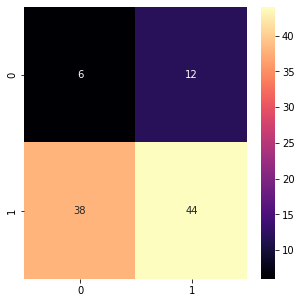

In [53]:
benchmark_train_acc = accuracy_score(y_train, dummy_clf.predict(x_train))
benchmark_test_acc = accuracy_score(y_test, y_pred)

print(f"Training accuracy of is : {benchmark_train_acc}")
print(f"Test accuracy of is : {benchmark_test_acc}")

plt.rcParams['figure.figsize'] = (5, 5)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cmap = 'magma')
plt.show()

In [54]:


lasso = linear_model.Lasso()
cv_results = cross_validate(lasso, x_test, y_test, cv=10)
sorted(cv_results.keys())
['fit_time', 'score_time', 'test_score']
cv_results['test_score']
cv_results= pd.DataFrame(cv_results)

In [55]:
print(cv_results.mean(axis = 0))
print(cv_results.std(axis = 0))

fit_time      0.002496
score_time    0.001574
test_score   -0.244598
dtype: float64
fit_time      0.000852
score_time    0.000559
test_score    0.358112
dtype: float64


# Question 3b

Depending on how you pre-processed your data, it is likely that you have many more features than necessary. 

Does the regularized version do better than the benchmark model in all aspects? Explain why or why not. 

As part of your answer, find a way to visualize and/or tabulate the cross validated scores.



In [56]:
cv_results.head()

,fit_time,score_time,test_score
0,0.003065,0.001512,0.096373
1,0.002721,0.002342,-0.062049
2,0.002985,0.001506,-0.569855
3,0.002507,0.002833,0.000000
4,0.004447,0.001375,-0.472893


# Question 4 

A basic building block for classification is the decision tree. Use `DecisionTreeClassifier` from `sklearn` to classify the same data. Which hyperparameters need to be chosen via cross validation?

Again, does your model do better than the previous models in all aspects? Explain why or why not.

Tabulate and/or visualize your performance.

In [57]:
# Your answer



dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)

y_pred = dtc.predict(x_test)


In [58]:
print(classification_report(y_train,dtc.predict(x_train)))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       229
           1       1.00      1.00      1.00       671

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900

              precision    recall  f1-score   support

           0       0.42      0.56      0.48        18
           1       0.89      0.83      0.86        82

    accuracy                           0.78       100
   macro avg       0.66      0.69      0.67       100
weighted avg       0.81      0.78      0.79       100



Training accuracy of is : 1.0
Test accuracy of is : 0.78


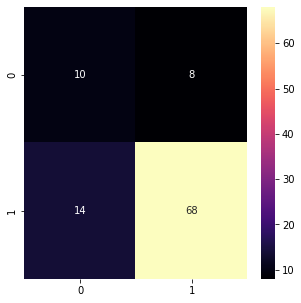

In [59]:
dct_train_acc = accuracy_score(y_train, dtc.predict(x_train))
dct_test_acc = accuracy_score(y_test, y_pred)

print(f"Training accuracy of is : {dct_train_acc}")
print(f"Test accuracy of is : {dct_test_acc}")

plt.rcParams['figure.figsize'] = (5, 5)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cmap = 'magma')
plt.show()

In [60]:

cv_results = cross_validate(lasso, x_test, y_test, cv=10)
sorted(cv_results.keys())
['fit_time', 'score_time', 'test_score']
cv_results['test_score']
cv_results= pd.DataFrame(cv_results)

In [61]:
print(cv_results.mean(axis = 0))
print(cv_results.std(axis = 0))

fit_time      0.003598
score_time    0.002362
test_score   -0.244598
dtype: float64
fit_time      0.000930
score_time    0.001368
test_score    0.358112
dtype: float64


In [62]:
cv_results.head()

,fit_time,score_time,test_score
0,0.003212,0.003421,0.096373
1,0.004287,0.003659,-0.062049
2,0.002808,0.001320,-0.569855
3,0.002508,0.001852,0.000000
4,0.005437,0.005461,-0.472893


Yes, overall performance has increased since the dummy estimator does not learn any patterns from the features, it uses simple heuristics to calculate the predictions

# Question 5 

We discussed Random Forests as extensions of Decision Trees. Implement the classification for `RandomForestClassifier`. Which hyperparameters are most relevant for your classification? 

Once again, does your model do better than the previous models in all aspects? Explain why or why not. 

Tabulate and/or visualize your performance.

In [63]:
# Your answer


rand_clf = RandomForestClassifier(criterion= 'entropy', max_depth= 10, max_features= 'sqrt', min_samples_leaf= 1, min_samples_split= 3, n_estimators= 140)
rand_clf.fit(x_train, y_train)

y_pred = rand_clf.predict(x_test)

In [64]:
print(classification_report(y_train,rand_clf.predict(x_train)))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       229
           1       0.99      1.00      0.99       671

    accuracy                           0.99       900
   macro avg       0.99      0.98      0.99       900
weighted avg       0.99      0.99      0.99       900

              precision    recall  f1-score   support

           0       0.61      0.61      0.61        18
           1       0.91      0.91      0.91        82

    accuracy                           0.86       100
   macro avg       0.76      0.76      0.76       100
weighted avg       0.86      0.86      0.86       100



Training accuracy of is : 0.9888888888888889
Test accuracy of is : 0.86


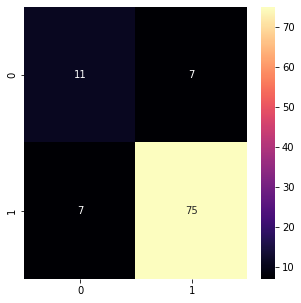

In [65]:
rand_clf_train_acc = accuracy_score(y_train, rand_clf.predict(x_train))
rand_clf_test_acc = accuracy_score(y_test, y_pred)

print(f"Training accuracy of is : {rand_clf_train_acc}")
print(f"Test accuracy of is : {rand_clf_test_acc}")

plt.rcParams['figure.figsize'] = (5, 5)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cmap = 'magma')
plt.show()

In [66]:

cv_results = cross_validate(lasso, x_test, y_test, cv=10)
sorted(cv_results.keys())
['fit_time', 'score_time', 'test_score']
cv_results['test_score']
cv_results= pd.DataFrame(cv_results)

In [67]:
print(cv_results.mean(axis = 0))
print(cv_results.std(axis = 0))

fit_time      0.002101
score_time    0.001595
test_score   -0.244598
dtype: float64
fit_time      0.000811
score_time    0.001004
test_score    0.358112
dtype: float64


In [68]:
cv_results.head()

,fit_time,score_time,test_score
0,0.002224,0.001315,0.096373
1,0.001818,0.001237,-0.062049
2,0.001817,0.001234,-0.569855
3,0.001781,0.004417,0.000000
4,0.004378,0.001718,-0.472893


Yes, Overall performance has increased since it is not highlt dependant on specific features and can generalize over the data in better way.

# Question 6

Use an ensemble model to make the best classification you can achieve. Please only consider the following model classes:
* Linear/logistic Regression
* Support Vector Machines
* Decision Trees and Random Forests
* Regularized versions of the above models.

The final classification score is as important as your explanation for its performance. That is, a model with excellent performance but no explanation for *why* it performs so well, is not sufficient.

Tabulate and/or visualize your performance.

**Hint:** `sklearn` has a `VotingClassifier` that can help you with this task.

              precision    recall  f1-score   support

           0       0.71      0.56      0.63        18
           1       0.91      0.95      0.93        82

    accuracy                           0.88       100
   macro avg       0.81      0.75      0.78       100
weighted avg       0.87      0.88      0.87       100

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       229
           1       0.99      1.00      0.99       671

    accuracy                           0.99       900
   macro avg       0.99      0.98      0.99       900
weighted avg       0.99      0.99      0.99       900



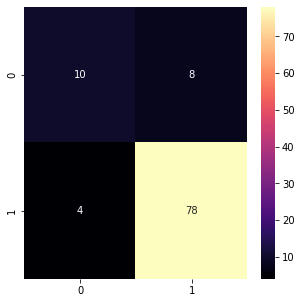

Training accuracy of is : 0.9888888888888889
Test accuracy of is : 0.88


In [72]:

svm_clf = SVC()
voting_clf = VotingClassifier( estimators=[('dtc', dtc), ('rf', rand_clf),
 ('svc', svm_clf)], voting='hard' )
voting_clf.fit(x_train, y_train)

y_pred = voting_clf.predict(x_test).astype(int)

cr = classification_report(y_test,  y_pred)
print(cr)

print(classification_report(y_train,rand_clf.predict(x_train)))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cmap = 'magma')
plt.show()

vc_train_acc = accuracy_score(y_train, rand_clf.predict(x_train))
vc_test_acc = accuracy_score(y_test, y_pred)

print(f"Training accuracy of is : {vc_train_acc}")
print(f"Test accuracy of is : {vc_test_acc}")


In [73]:
models = pd.DataFrame({
    'Model' : ['Benchmark', 'Decision Tree', 'Random Forest', 'Voting Classifier'],
    'Score' : [benchmark_test_acc, dct_test_acc, rand_clf_test_acc, vc_test_acc]
})


models.sort_values(by = 'Score', ascending = False)

,Model,Score
3,Voting Classifier,0.88
2,Random Forest,0.86
1,Decision Tree,0.78
0,Benchmark,0.50


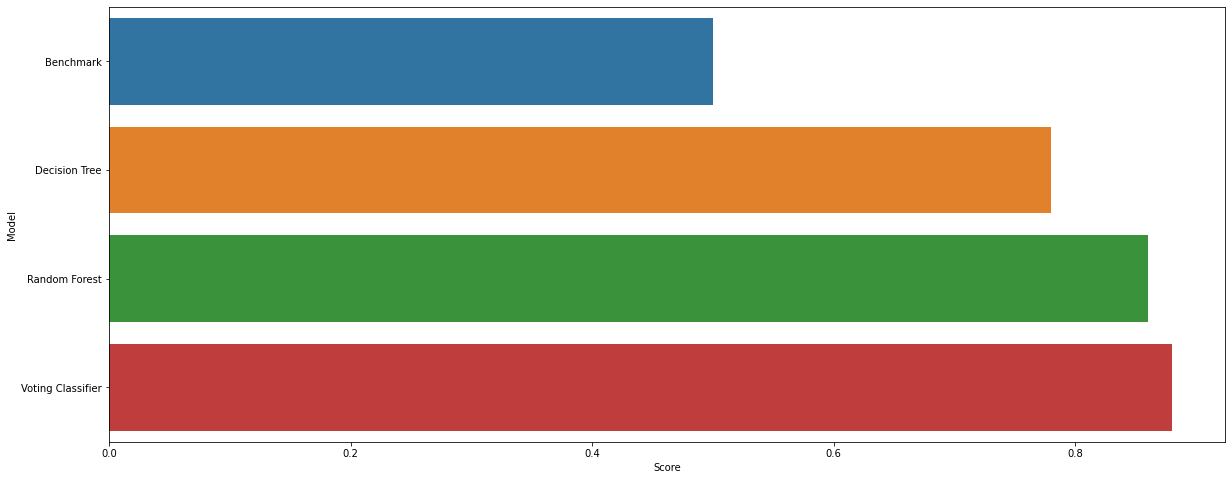

In [74]:
plt.figure(figsize = (20, 8))

sns.barplot(x = 'Score', y = 'Model', data = models)
plt.show()

Simply combining by voting some classifiers will naturally give bag results.Applying 3 classifiers for a set of data with 100 instance. Let's say on first 70 instances all classifiers match perfectly. Than on next 10 first classifier is good, the others are bad, on the next 10, the 2nd is good, others bad, and on the last 10 the 3rd is good, others are bad. All three models goes on with 0.80 accuracy. Voting them would lead to 0.70. but when all models in the ensemble have generally the same good performance the overall performance of voting classifer will be better. Hard voting is appropriate when the models used in the voting ensemble predict crisp class labels. Soft voting is appropriate when the models used in the voting ensemble predict the probability of class membership. So hard voting is used here. 